# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Mar 23 2022 13:33:55

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
neuron_model = [
    "edlif_psc_base.nestml", 
    "edlif_psc_nonlineardendrite.nestml",
    "edlif_psc_supply_state.nestml",
    "edlif_psc_supply_inline.nestml",
    "edlif_psc_percent.nestml"
]
neuron_id = 4
generate_nest_target(input_path=neuron_model[neuron_id],
                     target_path="/tmp/nestml-component",
                     logging_level="INFO",
                     codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/wis/Documents/nestml/ehp/edlif/edlif_psc_percent.nestml
[3,GLOBAL, INFO]: No module name specified; the generated module will be named "nestmlmodule"
[4,GLOBAL, INFO]: Start processing '/home/wis/Documents/nestml/ehp/edlif/edlif_psc_percent.nestml'!
[6,edlif_psc_percent, WARNING, [60:31;60:39]]: Non-matching unit types at pA +/- pA buffer! Implicitly replaced by pA +/- 1.0 * pA buffer.
[7,edlif_psc_percent, WARNING, [60:13;60:22]]: Non-matching unit types at mV / ms +/- pA / pF! Implicitly replaced by mV / ms +/- 1.0 * pA / pF.
[8,edlif_psc_percent, INFO, [24:15;24:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[9,edlif_psc_percent, INFO, [27:15;27:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[10,edlif_psc_percent, INFO, [28:15;28:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[11,edlif_psc_percent, INFO, [85:17;85:17]]: Implicit casting from (co

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + ((I_kernel_exc__X__exc_spikes - I_kernel_inh__X__inh_spikes) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "ATP' = (((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr / tau_ap * E_ap / o_t) + ((ATP_kernel_exc__X__exc_spikes + ATP_kernel_inh__X__inh_spikes) * 0.01 / 1.0) * 0))) * o_t",
            "initial_values": {
                "ATP": "100"
            }
        },
        {
            "expression": "I_kernel_inh__X__inh_spikes = exp(-t / tau_syn_inh)",
            "initial_values": {}
        },
        {
            "expression": "ATP_kernel_exc__X__exc_spikes = exp(-t / tau_syn_atp_exc)",
            "initial_values": {}
        },
        {
            "expression": "ATP_kernel_inh__X__inh_spikes = exp(-t / tau_syn_atp_inh)",
           



[21,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/home/wis/anaconda3/envs/wnestml/lib/python3.10/site-packages/pynestml/codegeneration/resources_nest/point_neuron'
[22,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/home/wis/anaconda3/envs/wnestml/lib/python3.10/site-packages/pynestml/codegeneration/resources_nest/point_neuron'
[23,GLOBAL, INFO]: The NEST installation was automatically detected as: /home/wis/anaconda3/envs/wnestml
[24,GLOBAL, INFO]: Analysing/transforming neuron 'edlif_psc_percent'
[25,edlif_psc_percent, INFO, [19:0;169:0]]: Starts processing of the model 'edlif_psc_percent'


INFO:	Returning shape: Shape "V_abs" of order 1
INFO:Shape V_abs: reconstituting expression -V_abs/tau_m + I_e/C_m + (I_kernel_exc__X__exc_spikes - I_kernel_inh__X__inh_spikes + I_stim)/C_m
INFO:
Processing differential-equation form shape ATP with defining expression = "(((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr / tau_ap * E_ap / o_t) + ((ATP_kernel_exc__X__exc_spikes + ATP_kernel_inh__X__inh_spikes) * 0.01 / 1.0) * 0))) * o_t"
INFO:	Returning shape: Shape "ATP" of order 1
INFO:Shape ATP: reconstituting expression (-E_ap*E_ap_tr + K_ATP*homeostatic_s_enabled*o_t*tau_ap*(-ATP + ATP_h))/tau_ap
INFO:
Processing function-of-time shape I_kernel_inh__X__inh_spikes with defining expression = "exp(-t/tau_syn_inh)"
INFO:Shape I_kernel_inh__X__inh_spikes: reconstituting expression -I_kernel_inh__X__inh_spikes/tau_syn_inh
INFO:
Processing function-of-time shape ATP_kernel_exc__X__exc_spikes with defining expression = "exp(-t/tau_syn_atp_exc)"
INFO:Shape

[27,edlif_psc_percent, INFO, [27:15;27:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[28,edlif_psc_percent, INFO, [28:15;28:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[29,edlif_psc_percent, INFO, [85:17;85:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[30,edlif_psc_percent, INFO, [92:17;92:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[31,edlif_psc_percent, INFO, [93:16;93:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[32,edlif_psc_percent, INFO, [94:16;94:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[33,edlif_psc_percent, INFO, [95:16;95:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[34,edlif_psc_percent, INFO, [97:18;97:18]]: Implicit casting from (compatible) type 'integer' to 'real'.
[35,edlif_psc_percent, INFO, [100:25;100:32]]: Implicit casting from (compatible) type 'integer' to 'real'.
[36,edlif_psc_percent, INFO, [132:30;132:30]

In [3]:
nest.Install("nestmlmodule")


Jun 22 11:56:42 Install [Info]: 
    loaded module nestmlmodule


Using neuron model: edlif_psc_percent
ATP: 100 
ATP: 100 
alpha: -1 
beta: 0 
V_abs: 0 mV
ATP: 99.9715 
ATP: 99.9458 
ATP: 99.9226 
ATP: 99.9016 
ATP: 99.8827 
ATP: 99.8657 
ATP: 99.8503 
ATP: 99.8364 
ATP: 99.824 
ATP: 99.8127 
ATP: 99.8026 
ATP: 99.7935 
ATP: 99.7854 
ATP: 99.778 
ATP: 99.7715 
ATP: 99.7656 
ATP: 99.7603 
ATP: 99.7555 
ATP: 99.7513 
ATP: 99.7476 
ATP: 99.7442 
ATP: 99.7412 
ATP: 99.7386 
ATP: 99.7363 
ATP: 99.7342 
ATP: 99.7324 
ATP: 99.7308 
ATP: 99.7294 
ATP: 99.7282 
ATP: 99.7272 
ATP: 99.7263 
ATP: 99.7256 
ATP: 99.725 
ATP: 99.7245 
ATP: 99.7241 
ATP: 99.7238 
ATP: 99.7236 
ATP: 99.7234 
ATP: 99.7233 
ATP: 99.7233 
ATP: 99.7233 
ATP: 99.7234 
ATP: 99.7235 
ATP: 99.7237 
ATP: 99.7239 
ATP: 99.7241 
ATP: 99.7244 
ATP: 99.7247 
ATP: 99.725 
ATP: 99.7253 
ATP: 99.915 
ATP: 99.915 
alpha: -1 
beta: 0.00680228 
V_abs: 0.102034 mV
ATP: 99.8866 
ATP: 99.8611 
ATP: 99.838 
ATP: 99.8173 
ATP: 99.7985 
ATP: 99.7816 
ATP: 99.7664 
ATP: 99.7528 
ATP: 99.7405 
ATP: 99.7294 
A

/tmp/ipykernel_18708/518095999.py:105: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/tmp/ipykernel_18708/518095999.py:105: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


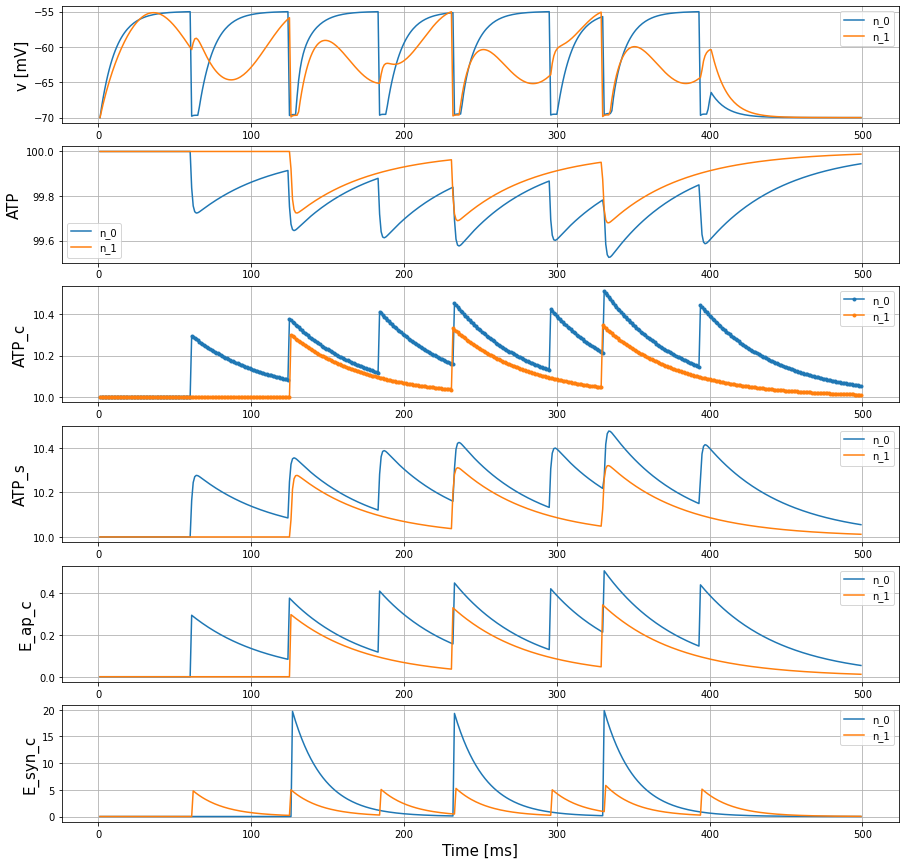

In [4]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

neuron_model_name = neuron_model[neuron_id].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

#param dict
parameter_dict = {"K_ATP": [1, 1]}
n = 1

# create neurons
pop1 = nest.Create(neuron_model_name, n, params=parameter_dict)
pop2 = nest.Create(neuron_model_name, n, params=parameter_dict)
voltmeter1 = nest.Create("voltmeter")
voltmeter2 = nest.Create("voltmeter")
voltmeter = [voltmeter1, voltmeter2]

# create connections
syn_dict = {#"synapse_model": "stdp_synapse", 
            "weight": 500,
            #"alpha": 1
            }
nest.Connect(pop1, pop2,
             "one_to_one",
             syn_spec=syn_dict)
syn_dict2 = {#"synapse_model": "stdp_synapse", 
            "weight": 2000,
            #"alpha": 1
            }
nest.Connect(pop2, pop1,
             "one_to_one",
             syn_spec=syn_dict2)

voltmeter[0].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
voltmeter[1].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter1, pop1)
nest.Connect(voltmeter2, pop2)

# current generators
dcs = nest.Create('dc_generator')
dcs.set({"amplitude": 376.01})   
dcs.set({"stop": 400})
acs = nest.Create('ac_generator')
acs.set({"amplitude": 150.2})
acs.set({"offset": 250.2})
acs.set({"frequency": 10})
acs.set({"stop": 400})
nest.Connect(dcs, pop1)
nest.Connect(acs, pop2)

# spike recorder
sr = nest.Create("spike_recorder")
nest.Connect(pop1, sr)
nest.Connect(pop2, sr)

nest.Simulate(500.)

# new arrays for reshaped arrays
ts = []
Vms = []
atp = []
atp_h = []
atp_c = []
atp_s = []
e_ap_c = []
e_syn_c = []
st = []

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))

for idx in range(2):
    # reshape arrays
    print(f"idx: {idx}")
    ts.append(voltmeter[idx].get("events")["times"])
    Vms.append(voltmeter[idx].get("events")["V_m"])
    atp.append(voltmeter[idx].get("events")["ATP"])
    atp_h.append(pop1.get("ATP_h"))
    atp_c.append(voltmeter[idx].get("events")["ATP_c"])
    atp_s.append(voltmeter[idx].get("events")["ATP_s"])
    e_ap_c.append(voltmeter[idx].get("events")["E_ap_c"])
    e_syn_c.append(voltmeter[idx].get("events")["E_syn_c"])
    
    # plot
    ax[0].plot(ts[idx], Vms[idx], label=f"n_{idx}")
    ax[1].plot(ts[idx], atp[idx], label=f"n_{idx}")
    #ax[1].axhline(y=atp_h[idx], ls="--")
    ax[2].plot(ts[idx], atp_c[idx], marker ='.', label=f"n_{idx}")
    #ax[2].axhline(y=pop1.get("ATP_basal"), ls="--")
    ax[3].plot(ts[idx], atp_s[idx], label=f"n_{idx}")
    ax[4].plot(ts[idx], e_ap_c[idx], label=f"n_{idx}")
    ax[5].plot(ts[idx], e_syn_c[idx], label=f"n_{idx}")
    for _ax in ax:
        _ax.grid(True)
        _ax.legend()
    ax[0].set_ylabel("v [mV]", fontsize=fontsize)
    ax[1].set_ylabel("ATP", fontsize=fontsize)
    ax[2].set_ylabel("ATP_c", fontsize=fontsize)
    ax[3].set_ylabel("ATP_s", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_tr", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_c", fontsize=fontsize)
    ax[5].set_ylabel("E_syn_c", fontsize=fontsize)
    ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
    
    fig.show()

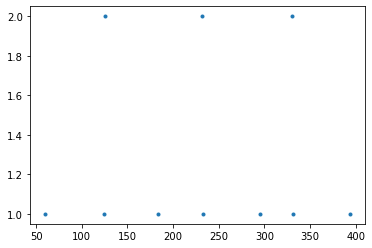

In [5]:
# extracting spikes data
dSD = sr.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.plot(ts, evs, ".")

In [6]:
conns = nest.GetConnections(synapse_model="stdp_synapse")

In [7]:
conns.get("weight")

()

In [8]:
conns.get("target")

()

In [9]:
conns.get(["source", "target","weight"])

()